[I 2025-08-15 23:33:34,606] A new study created in memory with name: no-name-9a0630e3-40e5-4471-b6fb-3d392acf7e66


Using device: cuda


[I 2025-08-15 23:33:38,905] Trial 0 finished with value: 0.12323198244064941 and parameters: {'lookback': 28, 'num_layers': 3, 'hidden_size': 45, 'lr': 0.0003458934939249751, 'batch_size': 16, 'kernel_size': 2}. Best is trial 0 with value: 0.12323198244064941.
[I 2025-08-15 23:33:42,337] Trial 1 finished with value: 0.09582245676556136 and parameters: {'lookback': 32, 'num_layers': 1, 'hidden_size': 106, 'lr': 0.0006910166371668867, 'batch_size': 16, 'kernel_size': 3}. Best is trial 1 with value: 0.09582245676556136.
[I 2025-08-15 23:33:43,840] Trial 2 finished with value: 0.13069198569261825 and parameters: {'lookback': 49, 'num_layers': 3, 'hidden_size': 25, 'lr': 0.0005567682413443146, 'batch_size': 32, 'kernel_size': 3}. Best is trial 1 with value: 0.09582245676556136.
[I 2025-08-15 23:33:44,986] Trial 3 finished with value: 0.09877391384076438 and parameters: {'lookback': 50, 'num_layers': 3, 'hidden_size': 89, 'lr': 0.005262120055565129, 'batch_size': 64, 'kernel_size': 3}. Best 

Best hyperparameters: {'lookback': 37, 'num_layers': 1, 'hidden_size': 22, 'lr': 0.0019708633271632845, 'batch_size': 32, 'kernel_size': 2}
Best validation RMSE: 0.08643186352462458
Multi-step Rolling Forecast (CNN+RNN, 1-day blocks) Test Metrics: {
  "MSE": 4.309816289704713,
  "RMSE": 2.076009703663428,
  "MAE": 1.7452432030125673,
  "MAPE%": 2.6634367849174234,
  "R2": 0.8769793250011255
}
Saved plot to cnn_rnn_pytorch_multistep_forecast_2024_1steps.png
Saved best params to best_cnn_rnn_params_multistep_1steps.json


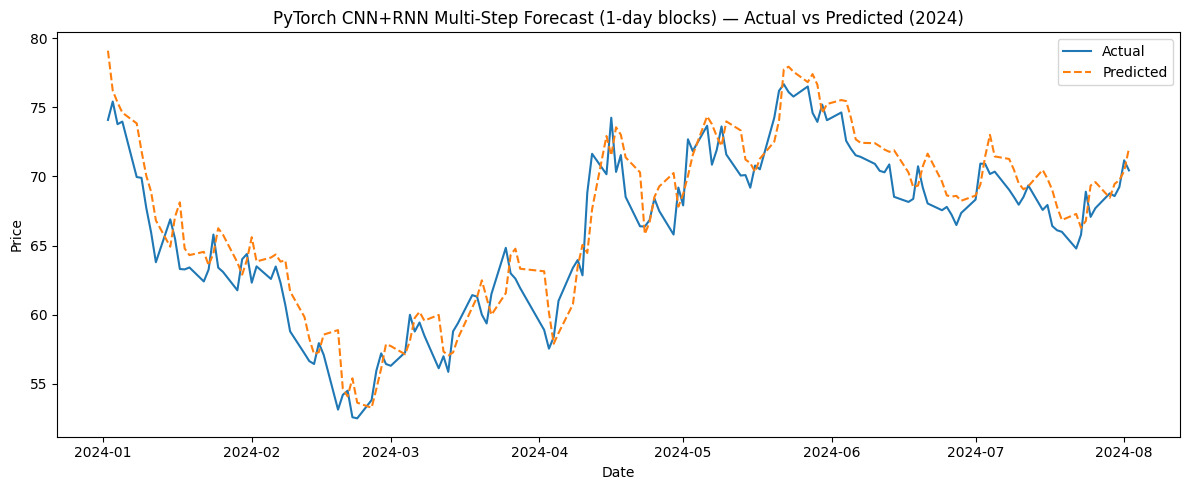

In [4]:
"""
Carbon Price Forecasting with PyTorch CNN+RNN
- Multi-step Rolling Forecast with user-defined steps.
- The model predicts a block of days at a time, then uses ground truth to advance the window.
- The model uses a 1D CNN for feature extraction followed by a simple RNN for sequential modeling.
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"
DATE_COL = "Date"
TARGET_COL = "Price"
FORECAST_STEPS = 1  # Number of steps to forecast ahead in a block

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test

def create_sequences(series_2d: np.ndarray, lookback: int):
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------- Model --------------------
class CNN_RNNRegressor(nn.Module):
    def __init__(self, lookback: int, input_size: int, hidden_size: int, num_layers: int, kernel_size: int):
        super().__init__()
        # 1. CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate the size of the output from the CNN layer
        # This is a bit tricky, so we do a dummy forward pass
        dummy_input = torch.randn(1, input_size, lookback)
        cnn_out_size = self.cnn(dummy_input).shape[2]

        # 2. RNN for sequential modeling
        self.rnn = nn.RNN(input_size=32, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # 3. Fully connected layer for the final output
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x is (batch, seq_len, input_size)
        
        # Permute for CNN: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        
        # Pass through CNN layer
        cnn_out = self.cnn(x)
        
        # Permute back for RNN: (batch, seq_len, features)
        # The new seq_len is cnn_out.shape[2] and features is 32
        rnn_in = cnn_out.permute(0, 2, 1)
        
        # Pass through RNN layer
        out, _ = self.rnn(rnn_in)
        
        # Take the output of the last time step and pass to the head
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)
    df_train, df_val, df_test = train_val_test_split(df)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    def objective(trial: optuna.Trial):
        lookback    = trial.suggest_int("lookback", 10, 50)  # Larger lookback for CNN
        num_layers  = trial.suggest_int("num_layers", 1, 3)
        hidden_sz   = trial.suggest_int("hidden_size", 16, 128, log=True)
        lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
        kernel_size = trial.suggest_int("kernel_size", 2, 5)
        epochs = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = CNN_RNNRegressor(lookback, input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0
        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return math.sqrt(best_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    best = study.best_params
    lookback    = best["lookback"]
    num_layers  = best["num_layers"]
    hidden_sz   = best["hidden_size"]
    lr          = best["lr"]
    batch_size  = best["batch_size"]
    kernel_size = best["kernel_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])
    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)
    model_final = CNN_RNNRegressor(lookback, input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    # -------------------- Multi-step rolling forecast loop --------------------
    history = trainval_scaled.tolist()
    preds_scaled = []
    y_test_scaled = full_scaler.transform(df_test[[TARGET_COL]]).tolist()

    with torch.no_grad():
        for i in range(0, len(df_test), FORECAST_STEPS):
            temp_history = history.copy()
            block_preds = []
            for _ in range(FORECAST_STEPS):
                x_in = np.array(temp_history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
                x_tensor = torch.from_numpy(x_in).to(device)
                yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
                block_preds.append(yhat)
                temp_history.append([yhat])
            
            preds_scaled.extend(block_preds)

            for j in range(FORECAST_STEPS):
                if i + j < len(df_test):
                    history.append(y_test_scaled[i + j])
                else:
                    break
    
    preds_scaled = preds_scaled[:len(df_test)]

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    # -------------------- Metrics & Plot --------------------
    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print(f"Multi-step Rolling Forecast (CNN+RNN, {FORECAST_STEPS}-day blocks) Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title(f'PyTorch CNN+RNN Multi-Step Forecast ({FORECAST_STEPS}-day blocks) — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'cnn_rnn_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png', dpi=150)
    print(f"Saved plot to cnn_rnn_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png")

    with open(f'best_cnn_rnn_params_multistep_{FORECAST_STEPS}steps.json', 'w') as f:
        json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    print(f"Saved best params to best_cnn_rnn_params_multistep_{FORECAST_STEPS}steps.json")